# Прогнозирование временных рядов на карте

<img src="nyc_yt.jpg" style="float:left; margin:20px;">

Ноутбук создает интерактивную карту с визуализацией реального и прогнозируемого спроса на желтое такси в Нью-Йорке в определенный момент времени, в определенном регионе города.

Под спросом в регионе понимается количество поездок, начавшихся в данном регионе за один истекший час. Для моделирования и прогнозирования работы желтого такси в Нью-Йорке были выбраны только наиболее активные регионы города &ndash; те, в которых среднее количество поездок за час в мае 2016 превысило некоторый порог. При обучении модели этот порог (`region_activity_threshold`) равнялся 5. Так были отобраны 102 региона. Во всех остальных местах города среднее количество поездок в час оказалось меньше 5. С помощью интерактивной карты, построенные с помощью модели прогнозы для этих областей можно сравнить с реальным значением спроса. Модель позволяет спрогнозировать значение на 1-6 часов вперед от выбранного момента времени. Интерактивная карта позволяет выбрать время в диапазоне от 2016-05-31 23:00:00 до 2016-06-30 17:00:00.

Ноутбук содержит только код для подготовки данных к визуализации и код для построения интерактивной карты. Прогнозы загружаются из предварительно созданных файлов.

В работе были использованы данные сайта [The Official Website of the City of New York](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipyleaflet import Map, basemaps, basemap_to_tiles, Polygon, WidgetControl
from os import listdir
from ipywidgets import HTML, VBox, DatePicker, Dropdown
from datetime import date
from string import ascii_letters, digits
from random import choice
from pathlib import Path

NYC_CENTER = (40.7058, -73.9778)

PREDICTS_DIR = Path('regression_test_predicts_14,200')
IMAGES_DIR = Path('images')

## 1. Агрегированные данные о количестве поездок

Загрузим агрегированные данные о поездках в мае 2016 года, а также данные о разбиении территории города Нью-Йорка и его окрестностей на 2500 регионов. Посчитаем среднее количество поездок из каждого региона и выберем самые активные регионы. Для более наглядной визуализации логарифмируем средние значения.

In [2]:
region_activity_threshold = 5
agg_data_filename = '2016-05_agg.csv'

agg_data = pd.read_csv(
    agg_data_filename, header=0, sep=',', index_col=['hour_bin'], parse_dates=['hour_bin'])
agg_data.columns = agg_data.columns.astype(int)
regions_sums = agg_data.sum(axis=0)
regions_sums = regions_sums.sort_index()
regions_data = pd.read_csv('regions.csv', header=0, sep=';', index_col='region')
regions_data['average_trip'] = regions_sums / float(agg_data.shape[0])
regions_data = regions_data[regions_data.average_trip >= region_activity_threshold]
print('Количество регионов со средним числом поездок больше {} равно {}.'.format(
    region_activity_threshold, regions_data.shape[0]))
average_trips_log = np.log1p(regions_data['average_trip'])
regions_data['average_trip_lognorm'] = average_trips_log / np.linalg.norm(average_trips_log, ord=np.inf)
regions_data.head(3)

Количество регионов со средним числом поездок больше 5 равно 102.


,west,east,south,north,average_trip,average_trip_lognorm
region,,,,,,
1075,-74.022246,-74.011135,40.697437,40.705825,66.799731,0.624077
1076,-74.022246,-74.011135,40.705825,40.714213,138.266129,0.730616
1077,-74.022246,-74.011135,40.714213,40.722601,86.802419,0.662341


## 2. Прогнозы на июнь 2016

Загрузим файлы с прогнозами на июнь 2016 и историческими (фактическими) значениями спроса.

In [3]:
predicts = {predicts_file[-5]:pd.read_csv(PREDICTS_DIR / predicts_file, index_col=0) 
            for predicts_file in listdir(PREDICTS_DIR)}
ordered_predicts = [None]*6
for shift, predict in predicts.items():
    short_index = []
    for i in predict.index:
        short_index.append(i[:-2])
    predict.index = short_index
    predict.columns = ['{}_{}'.format(c, shift) for c in predict.columns]
    ordered_predicts[int(shift)-1] = predict
predicts = pd.concat(ordered_predicts, axis=1)
predicts.head(3)

,history_1,predict_1,history_2,predict_2,history_3,predict_3,history_4,predict_4,history_5,predict_5,history_6,predict_6
1075_2016-05-31_23,26.0,32.614323,14.0,14.725247,5.0,5.077101,2.0,2.169475,1.0,1.118229,7.0,7.520819
1075_2016-06-01_0,14.0,13.907336,5.0,5.139053,2.0,2.052036,1.0,1.204155,7.0,7.329418,23.0,23.389133
1075_2016-06-01_1,5.0,5.155514,2.0,1.987714,1.0,1.007129,7.0,7.153829,23.0,23.766382,34.0,34.190050


In [4]:
history = predicts.iloc[:, [0,2,4,6,8,10]]
history.columns = ['+{} h.'.format(h) for h in range(1,7)]
history.head(3)

,+1 h.,+2 h.,+3 h.,+4 h.,+5 h.,+6 h.
1075_2016-05-31_23,26.0,14.0,5.0,2.0,1.0,7.0
1075_2016-06-01_0,14.0,5.0,2.0,1.0,7.0,23.0
1075_2016-06-01_1,5.0,2.0,1.0,7.0,23.0,34.0


In [5]:
predicts = predicts.iloc[:, [1,3,5,7,9,11]]
predicts.columns = ['+{} h.'.format(h) for h in range(1,7)]
predicts.head(3)

,+1 h.,+2 h.,+3 h.,+4 h.,+5 h.,+6 h.
1075_2016-05-31_23,32.614323,14.725247,5.077101,2.169475,1.118229,7.520819
1075_2016-06-01_0,13.907336,5.139053,2.052036,1.204155,7.329418,23.389133
1075_2016-06-01_1,5.155514,1.987714,1.007129,7.153829,23.766382,34.190050


## 3. Интерактивная карта

Интерактивная карта позволяет выбрать регион города, дату и час для сравнения реально возникшего спроса на такси в выбранном регионе и прогноза спроса на 1-6 часов вперед от выбранного момента времени в диапазоне от 2016-05-31 23:00:00 до 2016-06-30 17:00:00 с интервалом в 1 час.

In [6]:
def interactive_map(regions_data, history, predicts):
    u"""
    Функция создает виджет интерактивной карты.
    """
    date_hour = {'date':date(2016, 6, 23), 'hour':16}
    average_trips_map = Map(center=NYC_CENTER, zoom=11)
    map_layer = basemap_to_tiles(bm=basemaps.Stamen.Toner)
    cmap = plt.get_cmap(name='inferno')
    plot_cmap_gradient(cmap, title=u'Average number of trips per hour (May 2016)')
    interactive_content(
        regions_data=regions_data, history=history, predicts=predicts, 
        date_hour=date_hour, cmap=cmap, average_trips_map=average_trips_map, map_layer=map_layer)
    return average_trips_map

In [7]:
def plot_cmap_gradient(cmap, title):    
    u"""
    Функция строит и выводит изображение colormap в виде непрерывного градиента.
    """
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    fig = plt.figure(figsize=(5,.25))
    ax = plt.axes()
    ax.set_title(title, fontsize=14)
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    plt.yticks([])
    plt.xticks([0,256], ['min', 'max'])
    plt.show()

In [8]:
def interactive_content(**map_args):
    u"""
    Функция добавляет/обновляет полигоны карты и виджет контроля даты и времени.
    """
    def image_randtag(size=10, chars=ascii_letters+digits):
        return ''.join(choice(chars) for x in range(size))
    img_id = image_randtag()
    date_hour = map_args['date_hour']
    cmap = map_args['cmap']
    average_trips_map = map_args['average_trips_map']
    map_layer = map_args['map_layer']
    regions_data = map_args['regions_data']
    history = map_args['history']
    predicts = map_args['predicts']
    try:
        average_trips_map.clear_controls()
    except:
        pass
    average_trips_map.clear_layers()
    average_trips_map.add_layer(map_layer)
    most_active_regions_polygons = region_polygon_gen(
        regions_data, 
        use_col='average_trip_lognorm', 
        date_hour=date_hour, 
        img_id=img_id, 
        cmap=cmap, border_color='white')
    for region, polygon in most_active_regions_polygons:
        region_date_hour_history, region_date_hour_predict = region_history_predict(
            history, predicts, region, date_hour)
        save_region_img(region_date_hour_history, region_date_hour_predict, img_id)
        average_trips_map.add_layer(polygon)
    controls = create_controls(**map_args)
    average_trips_map.add_control(controls)

In [9]:
def region_polygon_gen(regions_data, date_hour, img_id, use_col, cmap, border_color=None):
    u"""
    Генератор цветных прямоугольных полигонов для отображения регионов (ячеек) на карте
    по данным столбца use_col из regions_data.
    """
    def same_colors(cmap, value):
        color = hex_color(cmap, value)
        return color, color
    def accent_colors(cmap, value):
        color = hex_color(cmap, value)
        return border_color, color
    colors = same_colors if border_color == None else accent_colors
    for region, region_data in regions_data.iterrows():
        region_color, region_fill_color = colors(cmap, value=region_data[use_col])
        yield region, Polygon(
            locations=polygon_location(region_data), 
            opacity=.5, 
            weight=1, 
            color=region_color, 
            fill_color=region_fill_color, 
            fill_opacity=.75, 
            popup=polygon_info(region_data, date_hour, img_id))

def hex_color(cmap, value):
    u"""
    Функция переводит значение value из диапазона [0.,1.] в строку шестнадцатиричного кода цвета, 
    используя объект colormap, возвращаемый функцией plt.get_cmap.
    """
    return '#'+''.join(map(lambda x: hex(x)[2:].zfill(2), cmap(value, bytes=True)[:-1]))
        
def polygon_location(region_data):
    u"""
    Функция выводит список пар координат вершин прямоугольного региона.
    """
    return [(region_data.north, region_data.west), (region_data.south, region_data.west), 
            (region_data.south, region_data.east), (region_data.north, region_data.east)]

def polygon_info(region_data, date_hour, img_id):
    u"""
    Функция формирует html-код, содержащий ссылку на изображение факта и прогноза спроса на ближайшие 6 часов.
    """
    day=date_hour['date']
    hour=date_hour['hour']
    region = region_data.name
    message = HTML()
    src = IMAGES_DIR / '{}_{}.png'.format(region, img_id)
    message.value = '<div style="width: 295px;"><img src="{}"></div>'.format(src)
    message.placeholder = 'Some HTML'
    return message

In [10]:
def region_history_predict(history, predicts, region, date_hour):
    day = str(date_hour['date'])
    hour = date_hour['hour']
    index = '{}_{}_{}'.format(region, day, hour)
    return history.loc[index], predicts.loc[index]

In [11]:
def save_region_img(region_date_hour_history, region_date_hour_predict, img_id):
    fig = plt.figure(figsize=(5,3.5))
    region, day, hour = region_date_hour_history.name.split('_')
    plt.title('Region {}, date {}, hour {}'.format(region, day, hour))
    plt.xlabel('from {} hour'.format(hour))
    plt.ylabel('trips per hour')
    plt.plot(region_date_hour_history, label='history', lw=6.0, ls='--')
    plt.plot(region_date_hour_predict, label='predict', lw=4.0)
    plt.legend()
    fig_name = IMAGES_DIR / '{}_{}.png'.format(region, img_id)
    plt.savefig(fig_name)
    plt.close(fig)

In [12]:
def create_controls(**map_args):
    u"""
    Функция возвращает виджет контроля даты и времени, обновляющий интерактивный контент карты.
    """
    date_hour = map_args['date_hour']
    controls = construct_controls(
        date_hour, 
        on_date_change=lambda change: update_interactive_content('date', change, **map_args), 
        on_hour_change=lambda change: update_interactive_content('hour', change, **map_args))
    return WidgetControl(widget=controls, position='topright')

def construct_controls(date_hour, on_date_change, on_hour_change):
    date_picker_item = DatePicker(value=date_hour['date'])
    hour_picker_item = Dropdown(options=range(1,24), value=date_hour['hour'])
    date_picker_item.observe(on_date_change, names='value')
    hour_picker_item.observe(on_hour_change, names='value')
    return VBox([date_picker_item, hour_picker_item])

def update_interactive_content(attr, change, **map_args):
    date_hour = map_args['date_hour']
    date_hour[attr] = change['new']
    interactive_content(**map_args)

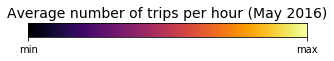

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [13]:
interactive_map(regions_data, history, predicts)